
# Compute GW by convex approximation
We want to have convex :
$$\min_{p \in R^{mn}_+} (c^t -2\lambda y^tH)p+p^t(Q +  \lambda R)p $$

We looking to slighly modify $R$ by $R_\epsilon$ to have $Q+\lambda R_\epsilon$ semi definite positive


Where $R=H^tH$ and $Q=-2 C_1\otimes C_2$


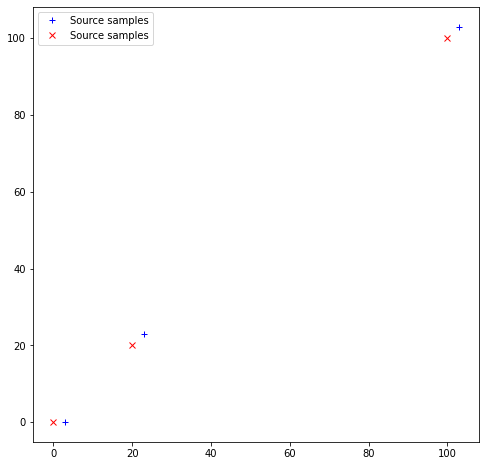

In [239]:
import numpy as np
import ot
import cvxpy as cp
import matplotlib.pylab as pl

#Data
n=4
m=4

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])
mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

#xs = ot.datasets.make_2D_samples_gauss(n-1, mu_s, cov_s)
#xt = ot.datasets.make_2D_samples_gauss(m-1, mu_t, cov_t)

xs=np.array([[3,0],[23,23],[103,103]])
xt=np.array([[0,0],[20,20],[100,100]])

fig = pl.figure(0,figsize=(8,8))
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Source samples')
pl.legend(loc=2)
pl.show()

### Weights of points ###
a=np.array([0,33,33,33])/100 # the first weight is 0 because it is only define for the embedding
b=np.array([0,33,33,33])/100

In [240]:
#Matrices of distance and embedding 

D1 = 10*ot.dist(xs, xs, metric='Minkowski')
#D1 = np.array([[0,1,2],[1,0,3],[2,3,0]])

D2 = 10*ot.dist(xt, xt, metric='Minkowski')
#D2 = np.array([[0,3,4],[3,0,5],[4,5,0]])

D1/=D1.max()
D2/=D2.max()

### Embedding in 4x4 matrices ###
C1=np.zeros((n,n))
C1[1:,1:]= D1
C1[0,1:]=-sum(D1) #first row
C1[1:,0]=-sum(D1.T) #first column
C1[0,0] = sum(sum(D1))

C2=np.zeros((m,m))
C2[1:,1:]=D2
C2[0,1:]=-sum(D2) #first row
C2[1:,0]=-sum(D2.T) #first column
C2[0,0]=sum(sum(D2))


print(D1,"\n",C1)
print(D2,"\n",C2)

[[0.         0.21231437 1.        ]
 [0.21231437 0.         0.78809129]
 [1.         0.78809129 0.        ]] 
 [[ 4.00081132 -1.21231437 -1.00040566 -1.78809129]
 [-1.21231437  0.          0.21231437  1.        ]
 [-1.00040566  0.21231437  0.          0.78809129]
 [-1.78809129  1.          0.78809129  0.        ]]
[[0.  0.2 1. ]
 [0.2 0.  0.8]
 [1.  0.8 0. ]] 
 [[ 4.  -1.2 -1.  -1.8]
 [-1.2  0.   0.2  1. ]
 [-1.   0.2  0.   0.8]
 [-1.8  1.   0.8  0. ]]


In [241]:
#Construction of H and R
Hr = np.reshape(np.repeat(np.eye(n),m), (n, n*m))
Ht = np.tile(np.eye(m),n)
H = np.vstack((Hr, Ht))
Rr = Hr.T@Hr
Rt = Ht.T@Ht
R=H.T@H

print(R)


[[2. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 2. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 2. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [1. 1. 1. 2. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 2. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 2. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 2. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 2. 0. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 2. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 1. 2. 1. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 2. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 2. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 2. 1. 1. 1.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 2. 1. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 2. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 2.]]


In [242]:
#Kronecker product of the distance
Q=-2*np.kron(C1,C2)
#print(Q)

In [243]:
#Check that R and Q a co-diagonalizable
print(np.round(Q@R-R@Q,10))

[[ 0.  0.  0.  0.  0. -0.  0. -0.  0. -0. -0. -0.  0. -0. -0. -0.]
 [ 0.  0.  0.  0. -0.  0.  0.  0. -0.  0.  0.  0. -0.  0.  0.  0.]
 [ 0.  0.  0. -0. -0.  0.  0.  0. -0.  0.  0.  0. -0. -0.  0.  0.]
 [ 0.  0.  0.  0. -0.  0.  0.  0. -0.  0. -0.  0. -0.  0.  0.  0.]
 [-0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.  0.  0. -0.  0.  0.]
 [ 0.  0. -0. -0.  0.  0.  0.  0. -0.  0. -0. -0.  0.  0.  0. -0.]
 [-0. -0.  0. -0.  0.  0.  0.  0.  0. -0.  0. -0. -0. -0.  0. -0.]
 [ 0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.]
 [-0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0. -0. -0.  0.]
 [ 0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.]
 [ 0. -0.  0.  0. -0.  0.  0. -0.  0.  0.  0.  0. -0.  0.  0. -0.]
 [ 0. -0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-0.  0.  0.  0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0.  0.  0.  0. -0.  0.  0.  0. -0.  0.  0.  0.  0.]
 [ 0. -0.  0. -0. -0. -0.  0. -0.  0. -0.  0. -0.  0.  0.  0. 

In [244]:
#The eigenvalue of R don't compensate the eigen value of Q 

print(np.real(np.linalg.eigvals(Q)))
print(np.real(np.linalg.eigvals(R)))

[-5.84197890e+01  1.30734618e+01  1.29284447e+01 -2.89318962e+00
  2.23931371e+00  2.11569972e+00 -5.01124409e-01 -4.68209612e-01
 -8.10977833e-02  1.50167036e-15  7.07098159e-16 -4.00371937e-16
 -4.00371937e-16  2.27913323e-16  1.33980013e-17  1.33980013e-17]
[ 0.00000000e+00  4.00000000e+00  8.00000000e+00  1.95496126e-16
 -3.27199609e-16  4.00000000e+00  4.00000000e+00  4.63248931e-16
 -3.62491333e-16  4.00000000e+00  4.00000000e+00  0.00000000e+00
  4.00000000e+00  2.91066339e-17  2.91066339e-17  2.35696271e-16]


In [245]:
# The eigenvalue of R are given by :
R_vp=np.array([0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,8])

#The eigenvectors are : 
P=np.array([
 [ 1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  0, -1, -1,  1, 1],
 [-1,  0,  0, -1,  0,  0, -1,  0,  0, -1, -1, -1,  0, -1,  1, 1],
 [ 0, -1,  0,  0, -1,  0,  0, -1,  0, -1, -1, -1, -1,  0,  1, 1],
 [ 0,  0, -1,  0,  0, -1,  0,  0, -1, -1, -1, -1, -1, -1,  2, 1],
 [-1, -1, -1,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0, -1, 1],
 [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0, -1, 1],
 [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1, -1, 1],
 [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, 1],
 [ 0,  0,  0, -1, -1, -1,  0,  0,  0,  0,  1,  1,  0,  0, -1, 1],
 [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0, -1, 1],
 [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  1, -1, 1],
 [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0, 1],
 [ 0,  0,  0,  0,  0,  0, -1, -1, -1,  0,  0,  1,  0,  0,  0, 1],
 [ 0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0, 1],
 [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0, 1],
 [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1, 1]])

P_inv=np.array([
 [ 1, -3,  1,  1, -3,  9, -3, -3,  1, -3,  1,  1,  1, -3,  1,  1],
 [ 1,  1, -3,  1, -3, -3,  9, -3,  1,  1, -3,  1,  1,  1, -3,  1],
 [ 1,  1,  1, -3, -3, -3, -3,  9,  1,  1,  1, -3,  1,  1,  1, -3],
 [ 1, -3,  1,  1,  1, -3,  1,  1, -3,  9, -3, -3,  1, -3,  1,  1],
 [ 1,  1, -3,  1,  1,  1, -3,  1, -3, -3,  9, -3,  1,  1, -3,  1],
 [ 1,  1,  1, -3,  1,  1,  1, -3, -3, -3, -3,  9,  1,  1,  1, -3],
 [ 1, -3,  1,  1,  1, -3,  1,  1,  1, -3,  1,  1, -3,  9, -3, -3],
 [ 1,  1, -3,  1,  1,  1, -3,  1,  1,  1, -3,  1, -3, -3,  9, -3],
 [ 1,  1,  1, -3,  1,  1,  1, -3,  1,  1,  1, -3, -3, -3, -3,  9],
 [-2, -2, -2,  2,  2,  2,  2,  6, -2, -2, -2,  2, -2, -2, -2,  2],
 [-2, -2, -2,  2, -2, -2, -2,  2,  2,  2,  2,  6, -2, -2, -2,  2],
 [ 2, -2, -2, -2,  2, -2, -2, -2,  2, -2, -2, -2,  6,  2,  2,  2],
 [-2,  2, -2, -2, -2,  2, -2, -2, -2,  2, -2, -2,  2,  6,  2,  2],
 [-2, -2,  2, -2, -2, -2,  2, -2, -2, -2,  2, -2,  2,  2,  6,  2],
 [-2, -2, -2,  2, -2, -2, -2,  2, -2, -2, -2,  2,  2,  2,  2,  6],
 [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])
P_inv=P_inv/16

print(P@np.diag(R_vp)@P_inv)

[[2. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 2. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 2. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [1. 1. 1. 2. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 2. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 2. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 2. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 2. 0. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 2. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 1. 2. 1. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 2. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 2. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 2. 1. 1. 1.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 2. 1. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 2. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 2.]]


In [246]:
# We do a slight modification of R by eps
eps=1e-1

R_vp_eps=np.array([eps,eps,eps,eps,eps,eps,eps,eps,eps,4,4,4,4,4,4,8]) #eigvalue of R
R_eps=P@np.diag(R_vp_eps)@P_inv


The quadratic part is given by :
$$Q+\lambda R_\epsilon$$

In [247]:
#We construct the quadratic part the problem

lam=-np.real(min(np.linalg.eigvals(Q)))/eps #In theory the minimum lambda to take
QR_eps=Q+lam*R_eps
print("lambda =" ,lam)

lambda = 584.1978900363586


The Linear par is given by :
$$(c^t -2\lambda y^tH)$$
where $c=vec(C_1^2a1_m^t+1_nb^tC_2^2)$

In [248]:
# We construct the linear part 

c=(C1@C1) @ np.tile(a,(4,1)).T + np.tile(b,(4,1))@ (C2@C2)
c=np.reshape(c,(1,16))
y_H=np.concatenate((a,b))@H
q=c-2*lam*y_H

In [249]:
## CVX minimization of min_p pq+p(Q+lam*R)p

p = cp.Variable(16)
objective = cp.Minimize(cp.quad_form(p,QR_eps)+q@p)

A=np.diag(np.array([1,1,1,1,1,0,0,0,1,0,0,0,1,0,0,0])) #Constraint p to be nul out of the "real support" (not necessary)
constraints = [0 <= p, A@p == 0]

prob = cp.Problem(objective, constraints)
result = prob.solve(verbose=False)
G1 = p.value
gw_app=np.array([[G1[5],G1[6],G1[7]], #The real support (minus the embedding)
                 [G1[9],G1[10],G1[11]],
                 [G1[13],G1[14],G1[15]]
    ])


In [250]:
### Compute Gromov-Wasserstein plans and distance with pot ###
p=a[1:]
q=b[1:]

gw0, log0 = ot.gromov.gromov_wasserstein(
    D1, D2, p, q, 'square_loss', verbose=False, log=True)




plot plan  
 [[0.33 0.   0.  ]
 [0.   0.33 0.  ]
 [0.   0.   0.33]]
convex plan  
 [[0.10942094 0.10958149 0.10899272]
 [0.10960025 0.10991944 0.10870157]
 [0.10898272 0.10871768 0.10993393]]
axb plan  
 [[0.1089 0.1089 0.1089]
 [0.1089 0.1089 0.1089]
 [0.1089 0.1089 0.1089]]


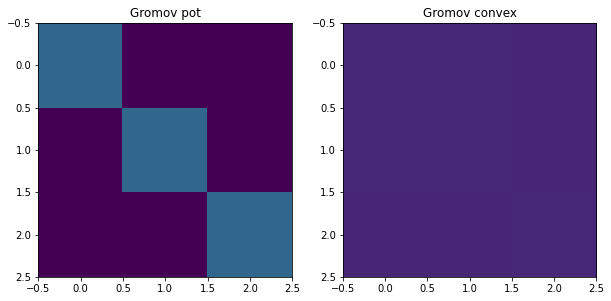

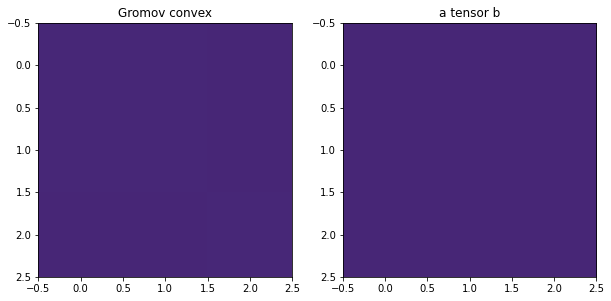

In [251]:
## Plot the Plans ###

a_tens_b= np.tile(q,(3,1))*np.tile(p,(3,1)).T #a tensor b

#Compare Gromov pot and Gromov convex
pl.figure(1, figsize=(10, 5))
pl.subplot(1, 2, 1)
pl.imshow(gw0,vmin=0,vmax=1)
pl.title('Gromov pot')
pl.subplot(1, 2, 2)
pl.imshow(gw_app,vmin=0,vmax=1)
pl.title('Gromov convex')

# Compare Gromov convex and a tensor b
pl.figure(2, figsize=(10,5))
pl.subplot(1, 2, 1)
pl.imshow(gw_app,vmin=0,vmax=1)
pl.title('Gromov convex')
pl.subplot(1, 2, 2)
pl.imshow(a_tens_b,vmin=0,vmax=1)
pl.title('a tensor b')

print("plot plan ","\n",gw0)
print("convex plan " ,"\n",gw_app)
print("axb plan ","\n",a_tens_b)

### The solution respect the marginal but the plan is always $a\otimes b$

# For this problem the eigenvalues are : 

In [252]:
print("Q :" , np.round(np.real(np.linalg.eigvals(Q))))
print("lambda*R_eps : " , np.round(np.real(np.linalg.eigvals(lam*R_eps))))
print("Q+lambda*R_eps : ", np.round(np.real(np.linalg.eigvals(QR_eps))))

Q : [-58.  13.  13.  -3.   2.   2.  -1.  -0.  -0.   0.   0.  -0.  -0.   0.
   0.   0.]
lambda*R_eps :  [  58. 2337. 4674.   58.   58. 2337. 2337.   58.   58. 2337. 2337. 2337.
   58.   58.   58.   58.]
Q+lambda*R_eps :  [4674.   -0.   71.   71.   56.   61.   61.   58.   58.   58. 2337. 2337.
 2337. 2337. 2337. 2337.]


#### We can see that the negative eigenvalues of Q are compensated but others are mooved unnecessarily

#### The idea is to consider R_eps=P @ [eps,0,0,0,0,0,0,0,0,4,4,4,4,4,4,8] @ P_inv instead

## Problem 1 Define like this R_eps is not symmetric :

In [253]:
R_vp_eps=np.array([eps,0,0,0,0,0,0,0,0,4,4,4,4,4,4,8]) #eigvalue of R
R_eps=P@np.diag(R_vp_eps)@P_inv
print(np.round(R_eps.T-R_eps,2))

[[ 0.    0.01 -0.01 -0.01  0.01 -0.05  0.02  0.02 -0.01  0.02 -0.01 -0.01
  -0.01  0.02 -0.01 -0.01]
 [-0.01  0.    0.01  0.01  0.    0.04 -0.02 -0.02  0.01 -0.02  0.01  0.01
   0.01 -0.02  0.01  0.01]
 [ 0.01 -0.01  0.    0.   -0.01  0.01  0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.01 -0.01  0.    0.   -0.01  0.01  0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [-0.01 -0.    0.01  0.01  0.    0.04 -0.02 -0.02  0.01 -0.02  0.01  0.01
   0.01 -0.02  0.01  0.01]
 [ 0.05 -0.04 -0.01 -0.01 -0.04  0.    0.02  0.02 -0.01  0.02 -0.01 -0.01
  -0.01  0.02 -0.01 -0.01]
 [-0.02  0.02  0.    0.    0.02 -0.02  0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [-0.02  0.02  0.    0.    0.02 -0.02  0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.01 -0.01  0.    0.   -0.01  0.01  0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [-0.02  0.02  0.    0.    0.02 -0.02  0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]
 [

#### It is because we considered $R_\epsilon = P D P^{-1}$ and not $R_\epsilon = P_0 D P_0^t$ with this eigenvectors

#### One can construct $P_0$ with numpy but the computation is not a good approximation
# Problem 2 The eigenvectors of numpy are not a good approximation
#### In particular $P_0 D P_0^t$ is not positive semi definite :

In [268]:
D,P=np.linalg.eig(R)

eps=1e-1
R_val=np.array([eps,4,8,0,0,4,4,0,0,4,4,0,4,0,0,0]) #eigvalue of R
R_test=P@np.diag(R_val)@P.T
print(np.real(np.round(R_test,1)))
print(np.round(np.real(np.linalg.eigvals(Q+lam*R_test)),2))

[[ 2.1  1.1  1.1  1.1  0.9  0.1  0.   0.   0.9  0.  -0.1 -0.   0.8  0.
  -0.1 -0.1]
 [ 1.1  2.   1.2  1.2  0.3  1.1  0.4  0.4 -0.1  0.7 -0.  -0.1 -0.3  0.5
  -0.2 -0.3]
 [ 1.1  1.2  2.1  1.2 -0.1  0.1  0.9  0.   0.2  0.4  1.2  0.3 -0.5 -0.3
   0.5 -0.4]
 [ 1.1  1.2  1.2  2.3 -0.2 -0.2 -0.1  0.9  0.   0.1  0.1  1.2 -0.3 -0.2
  -0.1  0.9]
 [ 0.9  0.3 -0.1 -0.2  1.9  1.3  0.8  0.7  0.9  0.2 -0.2 -0.4  1.2  0.6
   0.1 -0. ]
 [ 0.1  1.1  0.1 -0.2  1.3  2.3  1.2  1.  -0.1  0.9 -0.2 -0.4  0.   1.1
  -0.  -0.2]
 [ 0.   0.4  0.9 -0.1  0.8  1.2  1.7  0.7  0.2  0.6  1.1  0.  -0.2  0.2
   0.7 -0.3]
 [ 0.   0.4  0.   0.9  0.7  1.   0.7  1.6 -0.   0.3  0.   0.9  0.1  0.4
   0.1  1. ]
 [ 0.9 -0.1  0.2  0.   0.9 -0.1  0.2 -0.   1.7  0.8  1.   0.9  1.1  0.1
   0.4  0.2]
 [ 0.   0.7  0.4  0.1  0.2  0.9  0.6  0.3  0.8  1.4  1.1  0.9 -0.1  0.6
   0.2 -0. ]
 [-0.1 -0.   1.2  0.1 -0.2 -0.2  1.1  0.   1.   1.1  2.3  1.3 -0.3 -0.3
   1.  -0.1]
 [-0.  -0.1  0.3  1.2 -0.4 -0.4  0.   0.9  0.9  0.9  1.3  2.1 -0.1

# Problem 3 Computation of co-eigenvectors are not a good approximation
One can compute co-eigenvectors with qutip but it is not a good approximation and don't lead to a semi definite matrix $Q+\lambda R$

4672